<h1>Содержание<span class="tocSkip"></span></h1>
</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LGBMRegressor</a>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#импортируем все необходимые библиотеки и инструменты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose 

Чтобы преобразовать нужный столбец в датасете в тип данных datetime, передадим в функцию `read_csv` аргумент `parse_dates`. Индексировать данные будем по первому столбцу.

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(taxi.info())
taxi.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Наблюдения в датасете сделаны с разницей в 10 минут. Это слишком подробные данные. Выполним ресемплирование с интервалом в 1 час. Данные суммируем.

In [3]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()

In [4]:
display(taxi.info())
taxi.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные подготовлены. Проанализируем их.

## Анализ

Изучим данные - в какой промежуток времени велось наблюдение?

In [5]:
print("Начало наблюдения:", taxi.index.min())
print("Конец наблюдения:", taxi.index.max())

Начало наблюдения: 2018-03-01 00:00:00
Конец наблюдения: 2018-08-31 23:00:00


Нам предоставлены данные с марта по август (включительно) 2018 года.

Оценим данные на графике.

<AxesSubplot:xlabel='datetime'>

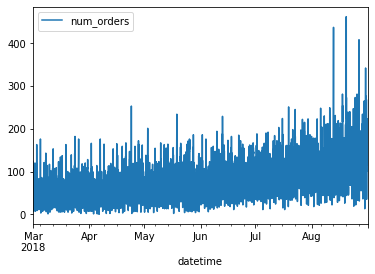

In [6]:
taxi.plot()

Мы не сможем изучить сезонность по предоставленным данным, так как информация есть только по срезу в полгода. Но можем оценить, как меняется объем заказов от первого наблюдения к последнему. Для наглядности ресемплируем данные по неделе и сохраним с новую переменную. Выведем на график.

<AxesSubplot:xlabel='datetime'>

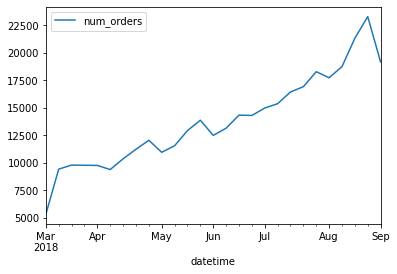

In [7]:
taxi_week = taxi.resample('1W').sum()
taxi_week.plot()

По графику можно сказать, что дела у сервиса по заказу такси идут хорошо - заказы увеличиваются от месяца к месяцу. Однако, однозначного решения принять нельзя - возможно, это стандартная практика у сервисов, и если бы мы взглянули на данные за несколько лет, то проследили бы закономерность.

С помощью функции `seasonal_decompose()` разложим временной ряд на три составляющие: тренд, сезонность и остаток (residuals) - это шум, который не объясняется трендом и сезонностью.

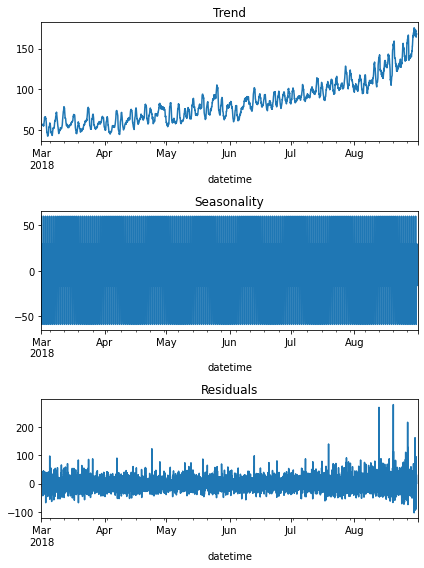

In [8]:
decomposed = seasonal_decompose(taxi['num_orders'], model='additive')

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Здесь также видно, что тренд растет от месяца к месяцу, но чтобы вывести сезонность нагляднее и изучить ее, ресемплируем данные по одному часу.

Рассмотим сезонность заказов на отдельном примере. Возьмем первую неделю августа.

Text(0.5, 1.0, 'Сезонность заказов в течение первых 7 дней августа')

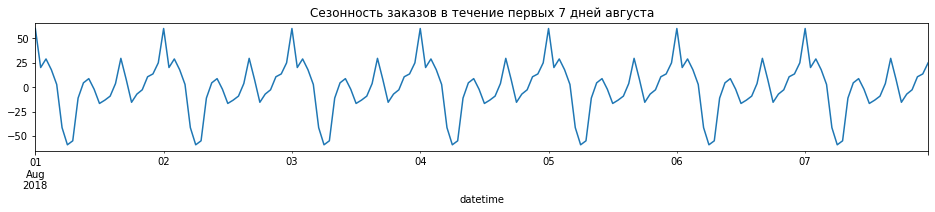

In [9]:
taxi_day = taxi.resample('1H').sum()

decomposed_day = seasonal_decompose(taxi_day)

plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed_day.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca())
plt.title("Сезонность заказов в течение первых 7 дней августа")

Наблюдаем каждодневную сезонность заказов. Рассмотрим на примере пары дней

<AxesSubplot:title={'center':'Сезонность заказов в течение первых 2 дней августа'}, xlabel='datetime'>

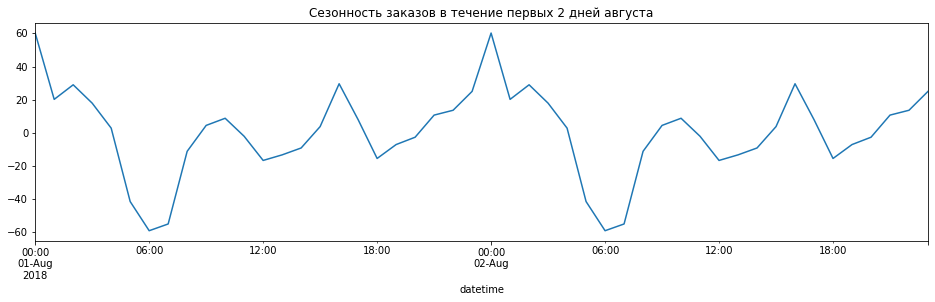

In [10]:
plt.figure(figsize=(16,4))
plt.title("Сезонность заказов в течение первых 2 дней августа")
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca())

Наблюдаем пик заказов полночь и спад заказов в 6 утра

На данном этапе мы выяснили, что наблюдается тренд в заказах на увеличение в течении года. Сезонность заказов в пике приходящееся на полночь и спада в 6 утра.

По полученным данным явно наличие увеличения заказов в течении года и ближе к полуночи. Уже сейчас мы можем с уверенностью сказать, что заказов увеличивается в 10 утра, 17 вечера и растет с 18 вечера до полуночи.

Найдем разности временного ряда. Станет ли он более стационарным, если применить метод `.shift()`?

<AxesSubplot:xlabel='datetime'>

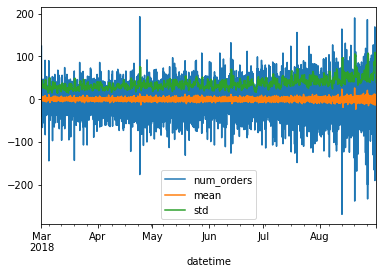

In [11]:
taxi_shifted = taxi - taxi.shift(fill_value=0)
taxi_shifted['mean'] = taxi_shifted['num_orders'].rolling(15).mean()
taxi_shifted['std'] = taxi_shifted['num_orders'].rolling(15).std()
taxi_shifted.plot()

Ряд становится более стационарным, а значит данные можно прогнозировать.

## Обучение

Для успешного обучения добавим признаки в датасет. Напишем функцию `make_features()`, которая:

- добавит к датасету четыре новых календарных признака: год, месяц, день и день недели,
- вычислит и добавит отстающие значения (предыдущие значения временного ряда, которые покажут, будет ли функция x(t) расти или уменьшаться),
- вычислит скользящее среднее и добавит его как признак `rolling_mean` - этот признак задаст общий тренд временного ряда.

In [12]:
def make_features(taxi, max_lag, rolling_mean_size):
    data = taxi.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [13]:
data = make_features(taxi, 24, 3)
data.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000


Разделим данные на обучающую и тестовую выборки, а затем поделим признаки.

Функция `train_test_split` по умолчанию перемешивает данные (что нам в данном случае не нужно), поэтому добавим параметр `shuffle=False`.

После применения функции `make_features` у нас появились NaN-значения за счет сдвига данных. Их никак не заполнить - просто избавимся от них.

In [14]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Проверим, что данные не перемешались - сравним последнее наблюдение признаков обучающей выборки и первое наблюдение признаков тестовой выборки.

In [15]:
print(features_train.index[features_train.shape[0]-1])
print(features_test.index[0])

2018-08-13 13:00:00
2018-08-13 14:00:00


Все верно, данные можно использовать для обучения.

Пропишу функцию для расчета метрики RMSE:

In [16]:
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse

Создадим функцию обучения наших моделей, поиска оптимальных гиперпараметров и значения метрики RMSE

В связи с тем, что мы работаем с временным рядом, нельзя применять кросс-валидацию в привычном виде для подбора гиперпараметров моделей с помощью GridSearchCV. Поэтому применим функцию TimeSeriesSplit().

In [17]:
def model_look(model, parameters):

    scorer = make_scorer(rmse_score, greater_is_better=False)
    tscv = TimeSeriesSplit(n_splits=5)
    model_grid = GridSearchCV(model, parameters, cv=tscv, scoring=scorer, verbose=5, n_jobs=-1)
    model_grid.fit(features_train, target_train)
    return model_grid.best_score_, model_grid.best_params_

### LinearRegression

In [18]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
rmse, best_parameters = model_look (LinearRegression(), parameters)
display('Лучшие параметры модели линейной регрессии:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............fit_intercept=True, normalize=True; total time=   0.0s
[CV 2/5] END .............fit_intercept=True, normalize=True; total time=   0.2s
[CV 3/5] END .............fit_intercept=True, normalize=True; total time=   0.2s
[CV 4/5] END .............fit_intercept=True, normalize=True; total time=   0.2s
[CV 5/5] END .............fit_intercept=True, normalize=True; total time=   0.2s
[CV 1/5] END ............fit_intercept=True, normalize=False; total time=   0.4s
[CV 2/5] END ............fit_intercept=True, normalize=False; total time=   0.1s
[CV 3/5] END ............fit_intercept=True, normalize=False; total time=   0.1s
[CV 4/5] END ............fit_intercept=True, normalize=False; total time=   0.2s
[CV 5/5] END ............fit_intercept=True, normalize=False; total time=   0.2s
[CV 1/5] END ............fit_intercept=False, normalize=True; total time=   0.1s
[CV 2/5] END ............fit_intercept=False, nor

'Лучшие параметры модели линейной регрессии:'

{'fit_intercept': False, 'normalize': True}

'Дали RMSE модели:'

-23170989728.142155

In [19]:
results = pd.DataFrame ({'model':['LinearRegression'], 'best_parameters_train':[best_parameters], 'RMSE_train':[rmse]})
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': False, 'normalize': True}",-2.317099e+10


### CatBoostRegressor

In [20]:
parameters = {'depth': range(2, 5, 1), 'iterations': range(18, 22, 1)}
rmse, best_parameters = model_look (CatBoostRegressor(loss_function="RMSE", \
                                                      learning_rate = 0.5), parameters)
display('Лучшие параметры модели CatBoostRegressor:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0:	learn: 25.3619346	total: 47ms	remaining: 799ms
1:	learn: 22.8808702	total: 47.8ms	remaining: 382ms
2:	learn: 21.9446526	total: 48.4ms	remaining: 242ms
3:	learn: 21.0787411	total: 49ms	remaining: 171ms
4:	learn: 20.4526965	total: 49.6ms	remaining: 129ms
5:	learn: 20.0206922	total: 50.1ms	remaining: 100ms
6:	learn: 19.5860006	total: 50.7ms	remaining: 79.6ms
7:	learn: 19.3891077	total: 51.3ms	remaining: 64.1ms
8:	learn: 19.1147138	total: 51.8ms	remaining: 51.8ms
9:	learn: 18.7960476	total: 52.4ms	remaining: 41.9ms
10:	learn: 18.5948544	total: 52.9ms	remaining: 33.7ms
11:	learn: 18.5425383	total: 53.5ms	remaining: 26.7ms
12:	learn: 18.3788503	total: 54ms	remaining: 20.8ms
13:	learn: 18.1458158	total: 54.6ms	remaining: 15.6ms
14:	learn: 17.9656165	total: 55.2ms	remaining: 11ms
15:	learn: 17.7959053	total: 55.8ms	remaining: 6.97ms
16:	learn: 17.7187536	total: 56.4ms	remaining: 3.32ms
17:	learn: 17.6111860	total: 57ms	remaining: 

'Лучшие параметры модели CatBoostRegressor:'

{'depth': 4, 'iterations': 21}

'Дали RMSE модели:'

-26.185236930536394

In [21]:
results = results.append({'model':'CatBoostRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': False, 'normalize': True}",-2.317099e+10
1,CatBoostRegressor,"{'depth': 4, 'iterations': 21}",-2.618524e+01


### LGBMRegressor

In [23]:
parameters = {'n_estimators':range(38, 42, 1)}
rmse, best_parameters = model_look (LGBMRegressor(random_state=12345), parameters)
display('Лучшие параметры модели LGBMRegressor:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................................n_estimators=38; total time=  18.8s
[CV 2/5] END ................................n_estimators=38; total time= 1.4min
[CV 3/5] END ................................n_estimators=38; total time= 1.3min
[CV 4/5] END ................................n_estimators=38; total time= 1.9min
[CV 5/5] END ................................n_estimators=38; total time= 1.5min
[CV 1/5] END ................................n_estimators=39; total time=  59.7s
[CV 2/5] END ................................n_estimators=39; total time= 1.5min
[CV 3/5] END ................................n_estimators=39; total time=  39.7s
[CV 4/5] END ................................n_estimators=39; total time=  14.9s
[CV 5/5] END ................................n_estimators=39; total time= 1.1min
[CV 1/5] END ................................n_estimators=40; total time=  30.1s
[CV 2/5] END ................................n_es

'Лучшие параметры модели LGBMRegressor:'

{'n_estimators': 41}

'Дали RMSE модели:'

-25.753923496989575

In [24]:
results = results.append({'model':'LGBMRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': False, 'normalize': True}",-2.317099e+10
1,CatBoostRegressor,"{'depth': 4, 'iterations': 21}",-2.618524e+01
2,LGBMRegressor,{'n_estimators': 41},-2.575392e+01


В процессе обучения моделей на обучающей выборке лучше всего себя показала модель линейной регрессии. Проверим качество предсказаний наших моделей на тестовой выборке

## Тестирование

Создадим функцию обучения моделей с выводом значения метрики RMSE и графическим представлением соотношений предсказаний с реальными значениями

In [25]:
def ml_result(model):
    
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    
    rmse = mean_squared_error(target_test, predictions)**0.5

    plt.figure(figsize=(15,5))
    plt.title('Сравнение реальных значений и предсказанных')

    plt.plot(target_test.index, predictions, 'r', label='Предсказания')
    plt.plot(target_test.index, target_test.values, 'g', label='Реальные значения')
    plt.legend(loc="upper left")
    plt.grid(True)
    
    return rmse

### LinearRegression

,model,best_parameters_train,RMSE_train,rmse_test
0,LinearRegression,"{'fit_intercept': False, 'normalize': True}",-2.317099e+10,45.291905
1,CatBoostRegressor,"{'depth': 4, 'iterations': 21}",-2.618524e+01,45.049955
2,LGBMRegressor,{'n_estimators': 41},-2.575392e+01,43.988476
3,NaN,NaN,NaN,45.049955
4,NaN,NaN,NaN,43.988476


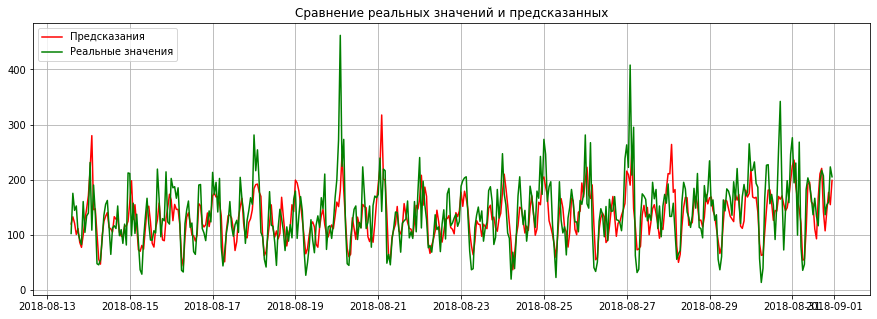

In [31]:
rmse = ml_result(LinearRegression(fit_intercept=True, normalize=False))
results.loc[0, 'rmse_test'] = rmse
results

### CatBoostRegressor

0:	learn: 31.5607624	total: 2.58ms	remaining: 51.7ms
1:	learn: 28.6334431	total: 5.25ms	remaining: 49.9ms
2:	learn: 27.1957190	total: 7.65ms	remaining: 45.9ms
3:	learn: 26.2693930	total: 9.94ms	remaining: 42.2ms
4:	learn: 25.6829323	total: 12.3ms	remaining: 39.5ms
5:	learn: 25.3545687	total: 14.6ms	remaining: 36.5ms
6:	learn: 25.2772558	total: 16.9ms	remaining: 33.7ms
7:	learn: 24.8975363	total: 19.2ms	remaining: 31.2ms
8:	learn: 24.6829293	total: 21.8ms	remaining: 29ms
9:	learn: 24.6100207	total: 24ms	remaining: 26.4ms
10:	learn: 24.3835204	total: 26.3ms	remaining: 23.9ms
11:	learn: 24.3376453	total: 28.5ms	remaining: 21.4ms
12:	learn: 24.1797893	total: 30.8ms	remaining: 18.9ms
13:	learn: 23.8956868	total: 33ms	remaining: 16.5ms
14:	learn: 23.7404136	total: 35.3ms	remaining: 14.1ms
15:	learn: 23.5424917	total: 37.6ms	remaining: 11.7ms
16:	learn: 23.4218473	total: 39.9ms	remaining: 9.38ms
17:	learn: 23.1888179	total: 42.5ms	remaining: 7.08ms
18:	learn: 22.9615482	total: 44.8ms	remainin

,model,best_parameters_train,RMSE_train,rmse_test
0,LinearRegression,"{'fit_intercept': False, 'normalize': True}",-2.317099e+10,45.291905
1,CatBoostRegressor,"{'depth': 4, 'iterations': 21}",-2.618524e+01,45.049955
2,LGBMRegressor,{'n_estimators': 41},-2.575392e+01,NaN
3,NaN,NaN,NaN,45.049955
4,NaN,NaN,NaN,43.988476


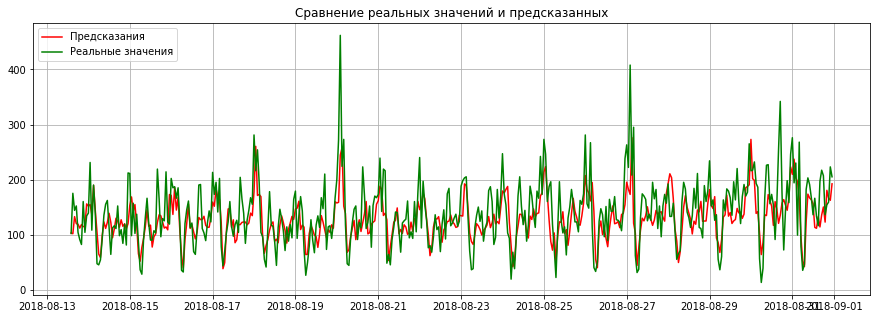

In [29]:
rmse = ml_result(CatBoostRegressor(loss_function="RMSE", learning_rate = 0.5, depth=4, iterations=21))
results.loc[1, 'rmse_test'] = rmse
results

### LGBMRegressor

,model,best_parameters_train,RMSE_train,rmse_test
0,LinearRegression,"{'fit_intercept': False, 'normalize': True}",-2.317099e+10,45.291905
1,CatBoostRegressor,"{'depth': 4, 'iterations': 21}",-2.618524e+01,45.049955
2,LGBMRegressor,{'n_estimators': 41},-2.575392e+01,43.988476
3,NaN,NaN,NaN,45.049955
4,NaN,NaN,NaN,43.988476


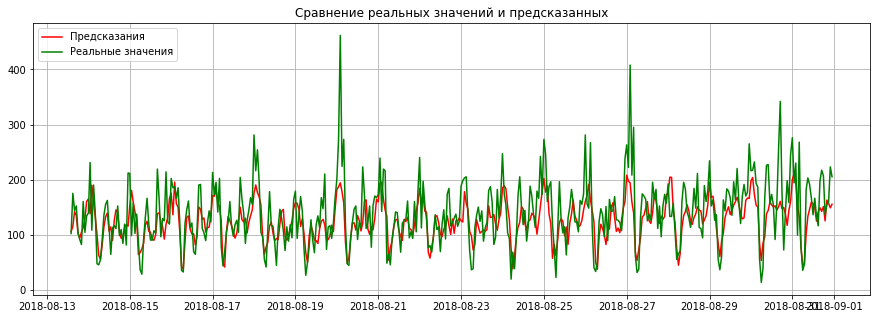

In [30]:
rmse = ml_result(LGBMRegressor(random_state=12345, n_estimators=41))
results.loc[2, 'rmse_test'] = rmse
results

**Вывод:**

Для получения результата в принятии решений в условиях задачи мной выполнено:

Рассемплирование временного ряда по часу, выявлены тренды и сезонность.

Обучила моделями линейной регрессии, CatBoostRegressor и LGBMRegressor

Нашела лучшие гиперпараметры данных моделей при обучении на обучающей выборке

Проверила модели с лучшими гиперпараметрами на тестовой выборке

В процессе проверки наших моделей на тестовой выборке все модели уложились в значение метрики RMSE не более 48. Наилучшие значения оказались у модели LGBMRegressor. Данную модель можно рекомендовать к исполнению.